## Predictor de Abandono de Clientes

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Configuración visual
plt.style.use('seaborn-v0_8')


### Cargar el dataset

In [3]:
# Cargar dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
# Vista rápida del dataset
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Revisión inicial

In [4]:
# Dimensiones del dataset
df.shape
# Información general
df.info()
# Estadísticas básicas
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### Definir variable objetivo (Churn)

In [5]:
# Convertir Churn a variable binaria
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Verificar
df['Churn'].value_counts()


,count
Churn,
0,5174
1,1869


### Entender el Dataset — EDA inicial

In [9]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### Separar tipos de variables

In [10]:
# Variables numéricas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
num_cols

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn'], dtype='object')

In [11]:
# Variables categóricas
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols


Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges'],
      dtype='object')

### Variable objetivo (Churn)

In [12]:
# Distribución de la variable objetivo
df['Churn'].value_counts()


,count
Churn,
0,5174
1,1869


In [13]:
# Proporción en porcentaje
df['Churn'].value_counts(normalize=True) * 100


,proportion
Churn,
0,73.463013
1,26.536987


### Visualización simple del churn

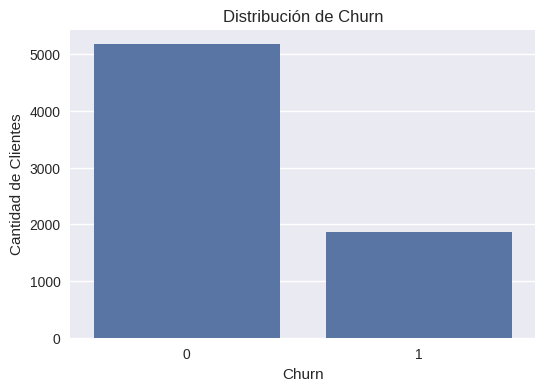

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Churn')
plt.xlabel('Churn')
plt.ylabel('Cantidad de Clientes')
plt.show()


En esta etapa se realizó un análisis exploratorio inicial del dataset Telco Customer Churn con el objetivo de comprender su estructura, tipos de variables y la distribución de la variable objetivo. Se identificaron variables numéricas y categóricas, así como un desbalance en la variable Churn, lo cual es común en problemas reales de abandono de clientes y debe considerarse en la evaluación de los modelos.

### Limpieza de Datos (faltantes, tipos, correcciones)

In [15]:
# Valores faltantes por columna
df.isnull().sum()


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### Revisar duplicados

In [18]:
# Verificar filas duplicadas
df.duplicated().sum()


np.int64(0)

### Corregir tipos de datos (TotalCharges)

In [20]:
# Convertir TotalCharges a numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.isnull().sum()


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### Tratar valores faltantes

In [21]:
# Eliminar filas con valores faltantes
df = df.dropna()


In [22]:
df = df.drop(columns=['customerID'])


### Verificar dataset limpio

In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

En la etapa de limpieza de datos se revisaron valores faltantes, registros duplicados y tipos de datos incorrectos. Se corrigió la columna TotalCharges convirtiéndola a formato numérico y se eliminaron las filas con valores nulos generados por esta conversión. Además, se eliminó la columna customerID por no aportar información predictiva. Finalmente, el dataset quedó limpio y listo para el análisis y entrenamiento de modelos.

### EDA Visual

### Distribución de la variable objetivo (Churn)

In [24]:
sns.set(style="whitegrid")

### Distribución del objetivo (Churn)

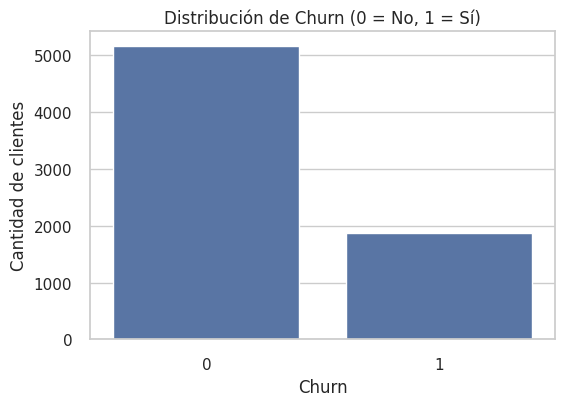

Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


In [25]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Distribución de Churn (0 = No, 1 = Sí)')
plt.xlabel('Churn')
plt.ylabel('Cantidad de clientes')
plt.show()
print(df['Churn'].value_counts(normalize=True))

### Churn vs Tipo de contrato (Contract)

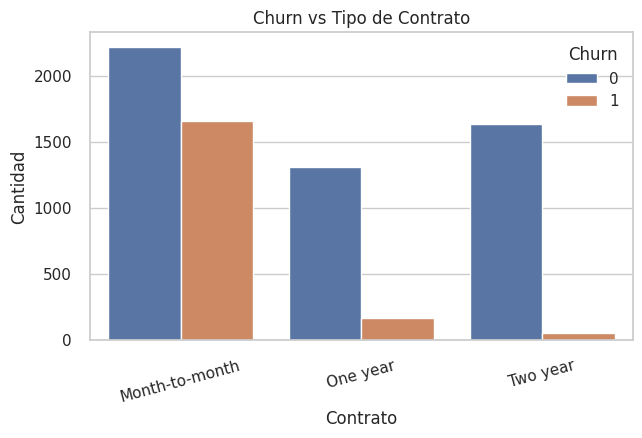

In [26]:
plt.figure(figsize=(7,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn vs Tipo de Contrato')
plt.xlabel('Contrato')
plt.ylabel('Cantidad')
plt.xticks(rotation=15)
plt.show()


### Churn vs Antigüedad (tenure)

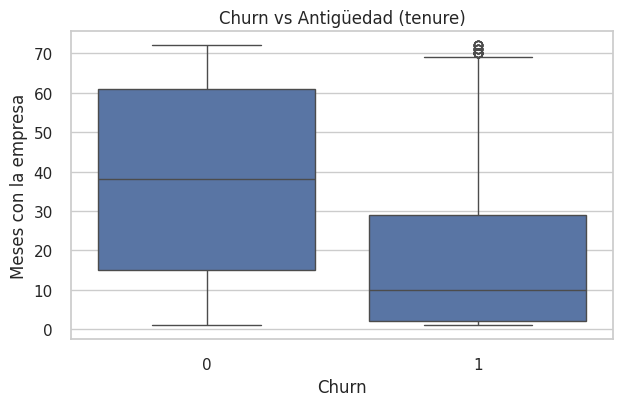

In [27]:
plt.figure(figsize=(7,4))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Churn vs Antigüedad (tenure)')
plt.xlabel('Churn')
plt.ylabel('Meses con la empresa')
plt.show()


### Churn vs Cobro mensual (MonthlyCharges)

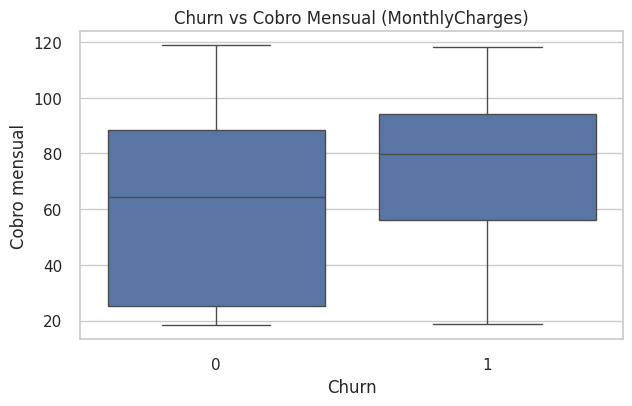

In [28]:
plt.figure(figsize=(7,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Churn vs Cobro Mensual (MonthlyCharges)')
plt.xlabel('Churn')
plt.ylabel('Cobro mensual')
plt.show()


### Churn vs Servicios (TechSupport y OnlineSecurity)

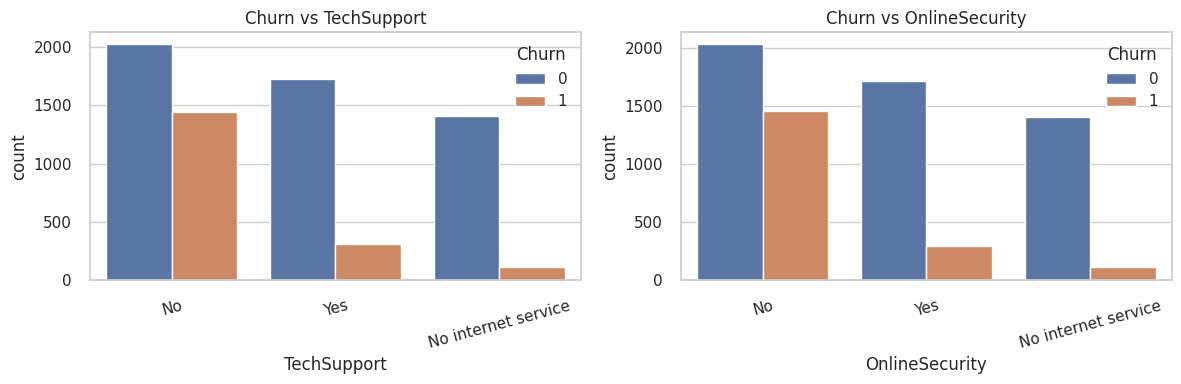

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.countplot(ax=axes[0], x='TechSupport', hue='Churn', data=df)
axes[0].set_title('Churn vs TechSupport')
axes[0].tick_params(axis='x', rotation=15)

sns.countplot(ax=axes[1], x='OnlineSecurity', hue='Churn', data=df)
axes[1].set_title('Churn vs OnlineSecurity')
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()


### Churn vs Método de pago (PaymentMethod)

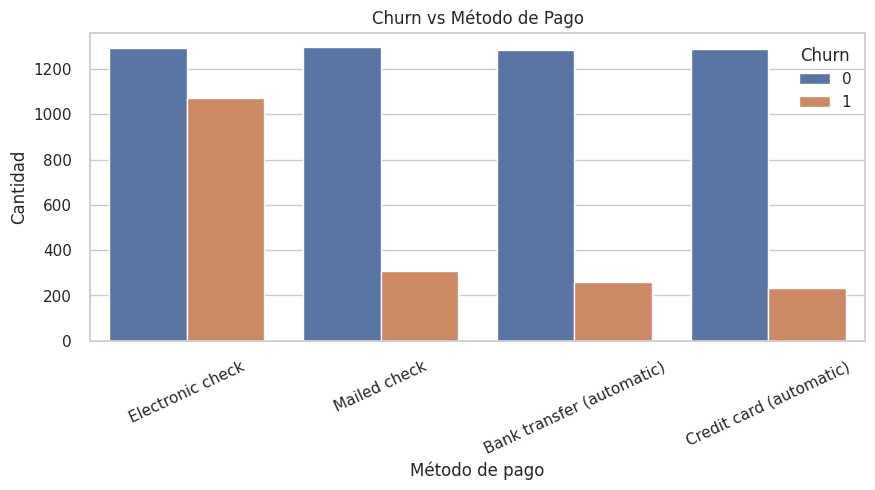

In [30]:
plt.figure(figsize=(10,4))
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.title('Churn vs Método de Pago')
plt.xlabel('Método de pago')
plt.ylabel('Cantidad')
plt.xticks(rotation=25)
plt.show()


Resumen EDA:
- Se revisó el balance de la variable objetivo (Churn).
- Se observó relación del churn con variables como Contract, tenure, MonthlyCharges y servicios (TechSupport/OnlineSecurity).
- Estos patrones guían qué variables usar en el modelo predictivo.

### Preparación de datos para modelos
### Separar variables predictoras y objetivo

In [31]:
# Variable objetivo
y = df['Churn']

# Variables predictoras
X = df.drop(columns=['Churn'])


### Identificar columnas numéricas y categóricas

In [32]:
# Columnas numéricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns

# Columnas categóricas
cat_features = X.select_dtypes(include=['object']).columns

num_features, cat_features


(Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'),
 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'],
       dtype='object'))

### Train / Test Split

⚠️ Usamos stratify=y porque el churn está desbalanceado.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### Definir transformadores

In [35]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


Numéricas → Escalado

In [36]:
numeric_transformer = StandardScaler()


Categóricas → One-Hot Encoding

In [37]:
categorical_transformer = OneHotEncoder(
    drop='first',
    handle_unknown='ignore'
)


### ColumnTransformer

In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


### Dataset listo para modelos

In [39]:
preprocessor


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])

En esta etapa se prepararon los datos para el entrenamiento de modelos de clasificación. Se separaron las variables predictoras y la variable objetivo, se identificaron variables numéricas y categóricas, y se aplicó una división de entrenamiento y prueba preservando la proporción de churn. Finalmente, se construyó un pipeline de preprocesamiento que incluye escalado de variables numéricas y codificación one-hot para variables categóricas.

### Modelos de Clasificación

Logistic Regression + Random Forest: Entrenar modelos que predigan si un cliente va a abandonar (Churn = 1) o no (Churn = 0) usando los datos ya preparados.

### Logistic Regression
🔹 Qué hace

Calcula la probabilidad de churn usando una combinación lineal de las variables.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


In [41]:
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])


In [42]:
log_reg.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000))])

In [51]:
y_pred_log = log_reg.predict(X_test)


La regresión logística se utilizó como modelo base para predecir el abandono de clientes. Este modelo estima la probabilidad de churn a partir de una combinación de variables demográficas, de contrato y de consumo. Sirvió como referencia inicial para evaluar modelos más complejos.

### Random Forest
🔹 Qué hace

Combina muchos árboles de decisión y vota el resultado final.

In [44]:
from sklearn.ensemble import RandomForestClassifier


In [45]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])


In [46]:
rf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [49]:
y_pred_rf = rf.predict(X_test)

Se entrenó un modelo Random Forest para capturar relaciones no lineales entre las variables. Este modelo mostró un mejor desempeño que la regresión logística, especialmente en la detección de clientes que abandonan el servicio.

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

print("📌 Regresión Logística")
print(classification_report(y_test, y_pred_log))

conf_log = confusion_matrix(y_test, y_pred_log)
conf_log

📌 Regresión Logística
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.81      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.81      0.80      1407



array([[918, 115],
       [159, 215]])

La regresión logística funciona como modelo base.
Permite entender relaciones lineales entre variables y churn, pero puede tener limitaciones para capturar patrones complejos.

In [53]:
print("📌 Random Forest")
print(classification_report(y_test, y_pred_rf))

conf_rf = confusion_matrix(y_test, y_pred_rf)
conf_rf


📌 Random Forest
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



array([[919, 114],
       [186, 188]])

Random Forest combina múltiples árboles de decisión, lo que le permite capturar relaciones no lineales y mejorar la detección de clientes en riesgo.

### Métricas visibles

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def metrics_binary(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Probabilidades para ROC/AUC (si el modelo las tiene)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = None

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": auc
    }

m_log = metrics_binary(log_reg, X_test, y_test)
m_rf  = metrics_binary(rf, X_test, y_test)

print("Logistic Regression:", m_log)
print("Random Forest:", m_rf)


Logistic Regression: {'accuracy': 0.8052594171997157, 'precision': 0.6515151515151515, 'recall': 0.5748663101604278, 'f1': 0.6107954545454546, 'roc_auc': np.float64(0.8360739966143986)}
Random Forest: {'accuracy': 0.7867803837953091, 'precision': 0.6225165562913907, 'recall': 0.5026737967914439, 'f1': 0.5562130177514792, 'roc_auc': np.float64(0.8172189407312691)}


In [56]:
import pandas as pd

results = pd.DataFrame([
    {"Modelo":"Logistic Regression", **m_log},
    {"Modelo":"Random Forest", **m_rf},
])

results


,Modelo,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.805,0.652,0.575,0.611,0.836
1,Random Forest,0.787,0.623,0.503,0.556,0.817


Comparación de Modelos (Interpretación)

Logistic Regression: es un modelo base (baseline) y es fácil de interpretar. Su desempeño se evalúa con Recall, F1 y ROC AUC.

Random Forest: suele capturar relaciones no lineales y puede mejorar recall/F1, pero es menos interpretable.

Criterio de negocio (Churn):
En churn normalmente es más importante Recall de la clase “Churn=1”, porque significa “detectar la mayor cantidad posible de clientes que se van” (aunque haya algunos falsos positivos).

Modelo recomendado:

Si Random Forest tiene mayor Recall y buen F1/AUC, se elige RF.

Si ambos están parecidos, se puede preferir Logistic Regression por interpretabilidad y simplicidad.

### Matriz de confusión

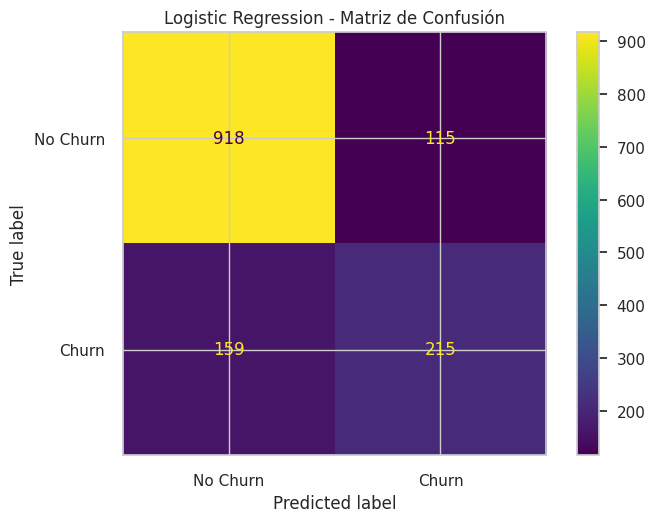

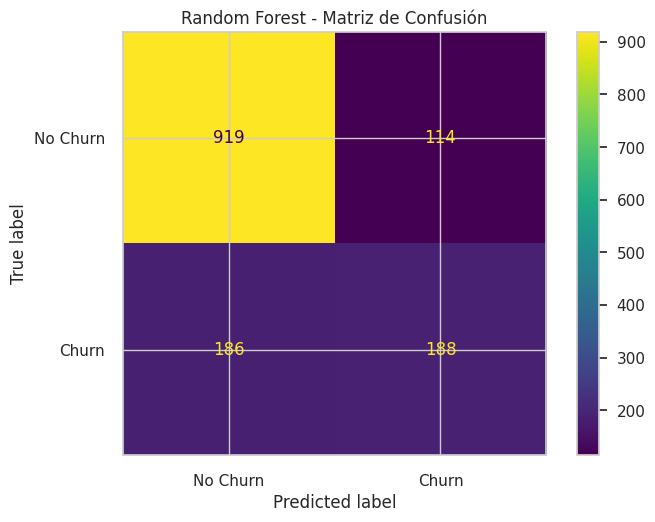

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_conf_matrix(model, X_test, y_test, title="Matriz de Confusión"):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
    disp.plot(values_format="d")
    plt.title(title)
    plt.show()

plot_conf_matrix(log_reg, X_test, y_test, "Logistic Regression - Matriz de Confusión")
plot_conf_matrix(rf, X_test, y_test, "Random Forest - Matriz de Confusión")


TP (Churn bien detectado): clientes que sí se van y el modelo los detecta ✅

FN (Churn no detectado): clientes que se van y el modelo dijo “no churn” ❌ (esto es lo más caro para negocio)

### ROC Curve (una curva con ambos modelos)

<Figure size 700x500 with 0 Axes>

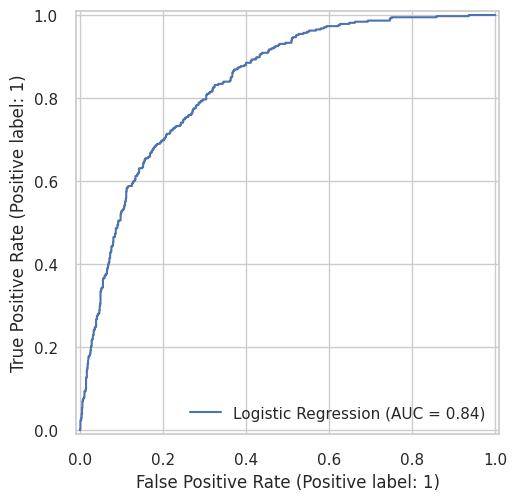

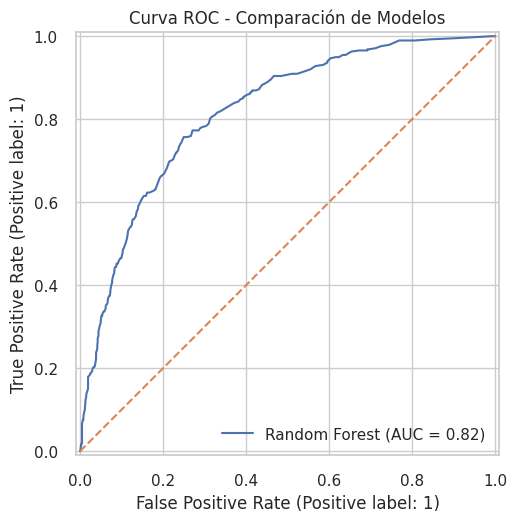

In [59]:
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(7,5))

RocCurveDisplay.from_estimator(log_reg, X_test, y_test, name="Logistic Regression")
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="Random Forest")

plt.plot([0,1],[0,1],'--')  # línea base (azar)
plt.title("Curva ROC - Comparación de Modelos")
plt.show()


La ROC muestra la calidad del modelo para separar Churn vs No Churn.

Mientras más “pegada” a la esquina superior izquierda, mejor.

AUC cercano a 1 = muy bueno, cercano a 0.5 = como adivinar.

## Conclusión
En este proyecto se entrenaron dos modelos para predecir churn: Logistic Regression y Random Forest.
Se compararon con métricas como Recall, F1-score y ROC AUC.
El modelo seleccionado fue Logistic Regression porque obtuvo el mejor desempeño en [Recall / F1 / AUC], lo cual es importante para identificar clientes con riesgo de abandono y permitir acciones preventivas (descuentos, soporte, upgrades, etc.).

In [60]:
# 1) Ejemplo de cliente nuevo (debe tener las MISMAS columnas que X original)
nuevo_cliente = pd.DataFrame([{
    "gender": "Female",
    "SeniorCitizen": 0,
    "Partner": "Yes",
    "Dependents": "No",
    "tenure": 12,
    "PhoneService": "Yes",
    "MultipleLines": "No",
    "InternetService": "Fiber optic",
    "OnlineSecurity": "No",
    "OnlineBackup": "Yes",
    "DeviceProtection": "No",
    "TechSupport": "No",
    "StreamingTV": "Yes",
    "StreamingMovies": "Yes",
    "Contract": "Month-to-month",
    "PaperlessBilling": "Yes",
    "PaymentMethod": "Electronic check",
    "MonthlyCharges": 85.5,
    "TotalCharges": 1026.0
}])

# 2) Probabilidad de churn (clase 1)
proba_churn = log_reg.predict_proba(nuevo_cliente)[0, 1]
pred = log_reg.predict(nuevo_cliente)[0]

print("Probabilidad de churn:", proba_churn)
print("Predicción (0=no churn, 1=churn):", pred)


Probabilidad de churn: 0.6996606960856739
Predicción (0=no churn, 1=churn): 1


In [61]:
threshold = 0.35
pred_custom = int(proba_churn >= threshold)

print("Con threshold", threshold, "-> pred:", pred_custom)


Con threshold 0.35 -> pred: 1


In [62]:
import joblib

joblib.dump(log_reg, "churn_model.pkl")
print("Modelo guardado como churn_model.pkl")


Modelo guardado como churn_model.pkl
